In [1]:
import pandas as pd
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import gzip

data = "810"
max_assembly = 5
min_samples = 6

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

/tmp/ipykernel_125812/2091253892.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/*.pkl")]

### Read in the data

In [3]:
with open(f'/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/binary/binary_{min_samples}.pkl', 'rb') as f:
	d = pickle.load(f)

/home/gomez/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:07:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [4]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			first_gene = s.sort_values(ascending=False).index[0]
			first_value = s.sort_values(ascending=False)[0]
			ner = d[rel][i][0][0]
			if len(s) >= 2:
				second_value = s.sort_values(ascending=False)[1]
				second_gene = s.sort_values(ascending=False).index[1]
			else:
				second_value = 0
				second_gene = ""
			if len(s) >= 3:
				third_value = s.sort_values(ascending=False)[2]
				third_gene = s.sort_values(ascending=False).index[2]
			else:
				third_value = 0
				third_gene = ""
			if len(s) >= 4:
				last_value = s.sort_values(ascending=False)[-1]
				last_gene = s.sort_values(ascending=False).index[-1]
			else:
				last_value = 0
				last_gene = ""
			l.append([rel, ner, first_value, first_gene, second_value, second_gene, third_value, third_gene, last_value, last_gene])


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_125812/2750966354.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_value = s.sort_values(ascending=False)[0]
/tmp/ipykernel_125812/2750966354.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_value = s.sort_values(ascending=False)[1]
/tmp/ipykernel_125812/2750966354.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  third_value = s.sort_values(ascending=False)[2]
/tmp/ipykernel_125812/2750966354.p

In [5]:
df = pd.DataFrame(l,columns=["rel","ner","first_value","first_gene","second_value","second_gene","third_value","third_gene","last_value","last_gene"])

In [6]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-SPECIES:INHIBITS,c. elegans,7.077722,Phospholipase D/Transphosphatidylase,4.125130,Type III secretion system substrate exporter,3.385655,"Terminase, large subunit gp17-like, C-terminal",1.564767,"Transposase, putative, helix-turn-helix domain"
1,STRAIN-SPECIES:INHIBITS,s. aureus,8.231627,Protein of unknown function DUF1827,8.106265,Peptidase M13,7.987250,Aminotransferase class IV,0.950399,"UvrD-like DNA helicase, C-terminal"
2,COMPOUND-STRAIN:INHIBITS,silver(i) complexes,0.590841,"Ribonucleotide reductase large subunit, C-term...",0.046518,"Type VI secretion system, RhsGE-associated Vgr...",0.002580,Peptidase S26,0.001536,"Resolvase-like, N-terminal catalytic domain su..."
3,COMPOUND-STRAIN:INHIBITS,methicillin,1.776067,"6-phosphogluconate dehydrogenase-like, C-termi...",1.045042,"Transport-associated OB, type 2",0.937731,Peptidase M56,0.054544,Head decoration protein D
4,COMPOUND-STRAIN:INHIBITS,eos,0.560589,Sodium/calcium exchanger membrane region,0.554175,Endonuclease/exonuclease/phosphatase superfamily,0.521822,"Pirin, C-terminal domain",0.017751,"Phage portal protein, lambda family"
...,...,...,...,...,...,...,...,...,...,...
1371,STRAIN-METABOLITE:PRODUCES,mda,1.853830,"Transcription regulator LuxR, C-terminal",1.683193,"Alpha-N-acetylglucosaminidase, N-terminal",1.604176,"Glycosyl transferase, family 14",0.000477,Structural maintenance of chromosomes protein
1372,STRAIN-METABOLITE:PRODUCES,methanobactin,3.492157,"Methanobactin precursor, Mb-OB3b",3.429901,High potential iron-sulphur protein,3.074488,Protein of unknown function DUF5765,0.000071,Outer membrane protein beta-barrel domain
1373,STRAIN-METABOLITE:PRODUCES,alkane,1.193534,Bifunctional molybdenum cofactor biosynthesis ...,0.945190,"Ferredoxin-NADP+ reductase, adrenodoxin-type",0.941559,"Acetyl-CoA carboxylase carboxyl transferase, b...",0.049283,Prohead protease
1374,STRAIN-METABOLITE:PRODUCES,lincomycin,4.362391,"Glycoside hydrolase, family 35",2.250539,Protein of unknown function DUF6668,1.900131,Phosphatase SCO2771,0.002625,ClpP/crotonase-like domain superfamily


In [7]:
cutoff = df[df["first_value"] > 0.15].sort_values("first_value")

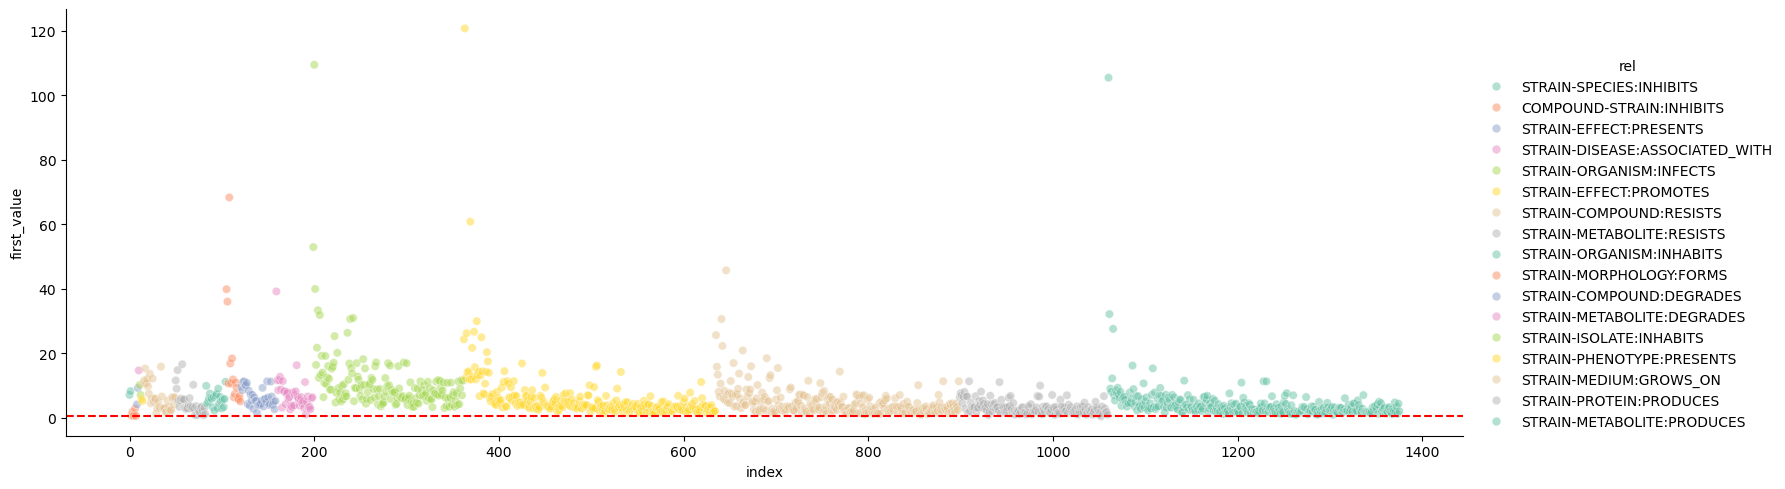

In [8]:
sns.relplot(y="first_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

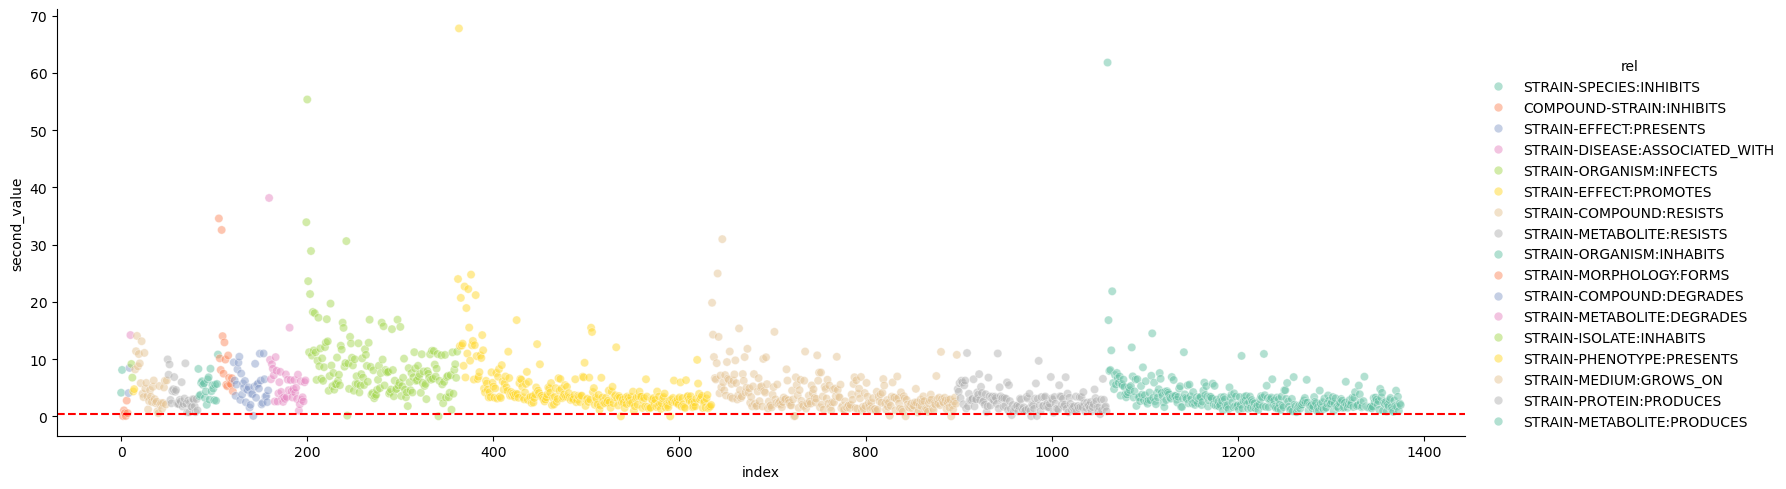

In [9]:
sns.relplot(y="second_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

<Axes: ylabel='Frequency'>

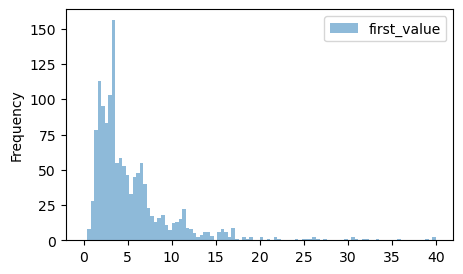

In [10]:
df.plot(kind='hist',y="first_value",bins=100,range=(0,40),alpha=0.5)

#### Group by function

In [11]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-SPECIES:INHIBITS,c. elegans,7.077722,Phospholipase D/Transphosphatidylase,4.125130,Type III secretion system substrate exporter,3.385655,"Terminase, large subunit gp17-like, C-terminal",1.564767,"Transposase, putative, helix-turn-helix domain"
1,STRAIN-SPECIES:INHIBITS,s. aureus,8.231627,Protein of unknown function DUF1827,8.106265,Peptidase M13,7.987250,Aminotransferase class IV,0.950399,"UvrD-like DNA helicase, C-terminal"
2,COMPOUND-STRAIN:INHIBITS,silver(i) complexes,0.590841,"Ribonucleotide reductase large subunit, C-term...",0.046518,"Type VI secretion system, RhsGE-associated Vgr...",0.002580,Peptidase S26,0.001536,"Resolvase-like, N-terminal catalytic domain su..."
3,COMPOUND-STRAIN:INHIBITS,methicillin,1.776067,"6-phosphogluconate dehydrogenase-like, C-termi...",1.045042,"Transport-associated OB, type 2",0.937731,Peptidase M56,0.054544,Head decoration protein D
4,COMPOUND-STRAIN:INHIBITS,eos,0.560589,Sodium/calcium exchanger membrane region,0.554175,Endonuclease/exonuclease/phosphatase superfamily,0.521822,"Pirin, C-terminal domain",0.017751,"Phage portal protein, lambda family"
...,...,...,...,...,...,...,...,...,...,...
1371,STRAIN-METABOLITE:PRODUCES,mda,1.853830,"Transcription regulator LuxR, C-terminal",1.683193,"Alpha-N-acetylglucosaminidase, N-terminal",1.604176,"Glycosyl transferase, family 14",0.000477,Structural maintenance of chromosomes protein
1372,STRAIN-METABOLITE:PRODUCES,methanobactin,3.492157,"Methanobactin precursor, Mb-OB3b",3.429901,High potential iron-sulphur protein,3.074488,Protein of unknown function DUF5765,0.000071,Outer membrane protein beta-barrel domain
1373,STRAIN-METABOLITE:PRODUCES,alkane,1.193534,Bifunctional molybdenum cofactor biosynthesis ...,0.945190,"Ferredoxin-NADP+ reductase, adrenodoxin-type",0.941559,"Acetyl-CoA carboxylase carboxyl transferase, b...",0.049283,Prohead protease
1374,STRAIN-METABOLITE:PRODUCES,lincomycin,4.362391,"Glycoside hydrolase, family 35",2.250539,Protein of unknown function DUF6668,1.900131,Phosphatase SCO2771,0.002625,ClpP/crotonase-like domain superfamily


In [12]:
df.value_counts("first_gene")

first_gene
Cytochrome b5-like heme/steroid binding domain     5
Exosortase D, VPLPA-CTERM-specific                 4
Extracellular matrix-binding protein Ebh domain    4
Protein of unknown function DUF3179                4
MBG domain, Lactobacillales                        3
                                                  ..
Glycoside hydrolase, family 16, active site        1
Glycoside hydrolase, family 25                     1
Glycoside hydrolase, family 27                     1
Glycoside hydrolase, family 35                     1
von Willebrand factor, type A                      1
Name: count, Length: 1211, dtype: int64

In [13]:
df[df["first_gene"]=="Cytochrome b5-like heme/steroid binding domain"]

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
454,STRAIN-PHENOTYPE:PRESENTS,non-,3.325226,Cytochrome b5-like heme/steroid binding domain,2.963030,Cytochrome b5-like heme/steroid binding domain...,2.865045,Domain of unknown function DUF3533,0.004777,Protein RseC
657,STRAIN-MEDIUM:GROWS_ON,trypticase soy broth,3.580994,Cytochrome b5-like heme/steroid binding domain,3.148228,PT repeat,3.065368,"dTDP-glucose 4,6-dehydratase",0.001333,YefM-like superfamily
797,STRAIN-MEDIUM:GROWS_ON,cba),2.343064,Cytochrome b5-like heme/steroid binding domain,1.664330,RNA polymerase sigma-70 like domain,1.283400,"Bacteriocin, class IIb, lactacin-related",0.001407,BRCT domain
893,STRAIN-MEDIUM:GROWS_ON,atcc medium 1685,2.386765,Cytochrome b5-like heme/steroid binding domain,1.963271,Atypical Rib domain,1.472704,Protein of unknown function DUF4838,0.002198,"Solute-binding family 1, conserved site"
897,STRAIN-MEDIUM:GROWS_ON,gardnerella selective agar,2.386615,Cytochrome b5-like heme/steroid binding domain,2.201853,Atypical Rib domain,1.539608,Protein of unknown function DUF4838,0.003491,Bifunctional aldehyde-alcohol dehydrogenase


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [14]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
assemblies = pd.concat(assemblies_perner)

In [16]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [17]:
merged_df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count
0,STRAIN-SPECIES:INHIBITS,c. elegans,7.077722,Phospholipase D/Transphosphatidylase,4.125130,Type III secretion system substrate exporter,3.385655,"Terminase, large subunit gp17-like, C-terminal",1.564767,"Transposase, putative, helix-turn-helix domain",6
1,STRAIN-SPECIES:INHIBITS,s. aureus,8.231627,Protein of unknown function DUF1827,8.106265,Peptidase M13,7.987250,Aminotransferase class IV,0.950399,"UvrD-like DNA helicase, C-terminal",6
2,COMPOUND-STRAIN:INHIBITS,silver(i) complexes,0.590841,"Ribonucleotide reductase large subunit, C-term...",0.046518,"Type VI secretion system, RhsGE-associated Vgr...",0.002580,Peptidase S26,0.001536,"Resolvase-like, N-terminal catalytic domain su...",7
3,COMPOUND-STRAIN:INHIBITS,methicillin,1.776067,"6-phosphogluconate dehydrogenase-like, C-termi...",1.045042,"Transport-associated OB, type 2",0.937731,Peptidase M56,0.054544,Head decoration protein D,7
4,COMPOUND-STRAIN:INHIBITS,eos,0.560589,Sodium/calcium exchanger membrane region,0.554175,Endonuclease/exonuclease/phosphatase superfamily,0.521822,"Pirin, C-terminal domain",0.017751,"Phage portal protein, lambda family",6
...,...,...,...,...,...,...,...,...,...,...,...
1371,STRAIN-METABOLITE:PRODUCES,mda,1.853830,"Transcription regulator LuxR, C-terminal",1.683193,"Alpha-N-acetylglucosaminidase, N-terminal",1.604176,"Glycosyl transferase, family 14",0.000477,Structural maintenance of chromosomes protein,6
1372,STRAIN-METABOLITE:PRODUCES,methanobactin,3.492157,"Methanobactin precursor, Mb-OB3b",3.429901,High potential iron-sulphur protein,3.074488,Protein of unknown function DUF5765,0.000071,Outer membrane protein beta-barrel domain,6
1373,STRAIN-METABOLITE:PRODUCES,alkane,1.193534,Bifunctional molybdenum cofactor biosynthesis ...,0.945190,"Ferredoxin-NADP+ reductase, adrenodoxin-type",0.941559,"Acetyl-CoA carboxylase carboxyl transferase, b...",0.049283,Prohead protease,6
1374,STRAIN-METABOLITE:PRODUCES,lincomycin,4.362391,"Glycoside hydrolase, family 35",2.250539,Protein of unknown function DUF6668,1.900131,Phosphatase SCO2771,0.002625,ClpP/crotonase-like domain superfamily,6


In [18]:
merged_df.sort_values("count")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count
0,STRAIN-SPECIES:INHIBITS,c. elegans,7.077722,Phospholipase D/Transphosphatidylase,4.125130,Type III secretion system substrate exporter,3.385655,"Terminase, large subunit gp17-like, C-terminal",1.564767,"Transposase, putative, helix-turn-helix domain",6
632,STRAIN-PHENOTYPE:PRESENTS,chemolithoautotroph,1.667720,Fimbrial protein pilin,1.619318,Cold-shock (CSD) domain,1.611867,Gram-negative bacterial TonB protein,0.000976,"Glycine-tRNA ligase, beta subunit",6
631,STRAIN-PHENOTYPE:PRESENTS,alpha-,1.431002,Acriflavin resistance protein,1.424946,Polysaccharide chain length determinant N-term...,1.328617,Protein of unknown function DUF6165,0.001437,Precorrin-6Y methyltransferase,6
630,STRAIN-PHENOTYPE:PRESENTS,cyanobacterial,3.890949,APAF-1 helical domain,3.727259,"NADH:ubiquinone oxidoreductase chain 4, N-term...",3.461818,"Transposase, Synechocystis PCC 6803",0.124762,Tetratricopeptide repeat,6
629,STRAIN-PHENOTYPE:PRESENTS,carboxydotrophic,3.159674,Domain of unknown function DUF4213,3.127653,"Acetaldehyde dehydrogenase, acetylating",3.127651,"GPCR, family 2, secretin-like",0.077168,Peptidase M23,6
...,...,...,...,...,...,...,...,...,...,...,...
1060,STRAIN-METABOLITE:PRODUCES,c,105.438171,Pr6Pr membrane protein-like,61.823261,"Aspartate-tRNA ligase, type 1, anticodon recog...",51.560860,"Orc1-like, AAA ATPase domain",0.002101,"Phosphoenolpyruvate carboxykinase, ATP-utilising",230
199,STRAIN-ISOLATE:INHABITS,soil,52.905560,Condensation domain,33.917496,Non-ribosomal peptide synthase,24.342966,ACP-like superfamily,0.021487,Restriction system protein Mrr-like N-terminal...,234
105,STRAIN-MORPHOLOGY:FORMS,biofilm,39.841034,Helicase SWF/SNF-related,34.578350,Inositol monophosphatase-like,21.493536,"Large ribosomal subunit protein eL14, KOW motif",0.001648,Phosphofructokinase domain,386
363,STRAIN-PHENOTYPE:PRESENTS,gram - positive,120.727089,Sporulation regulator WhiA,67.790810,Permease LptG/LptF-related,38.348106,Bacterial surface antigen (D15),0.004369,Type IV secretion system protein TraG/VirD4,421


/tmp/ipykernel_125812/1829732332.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


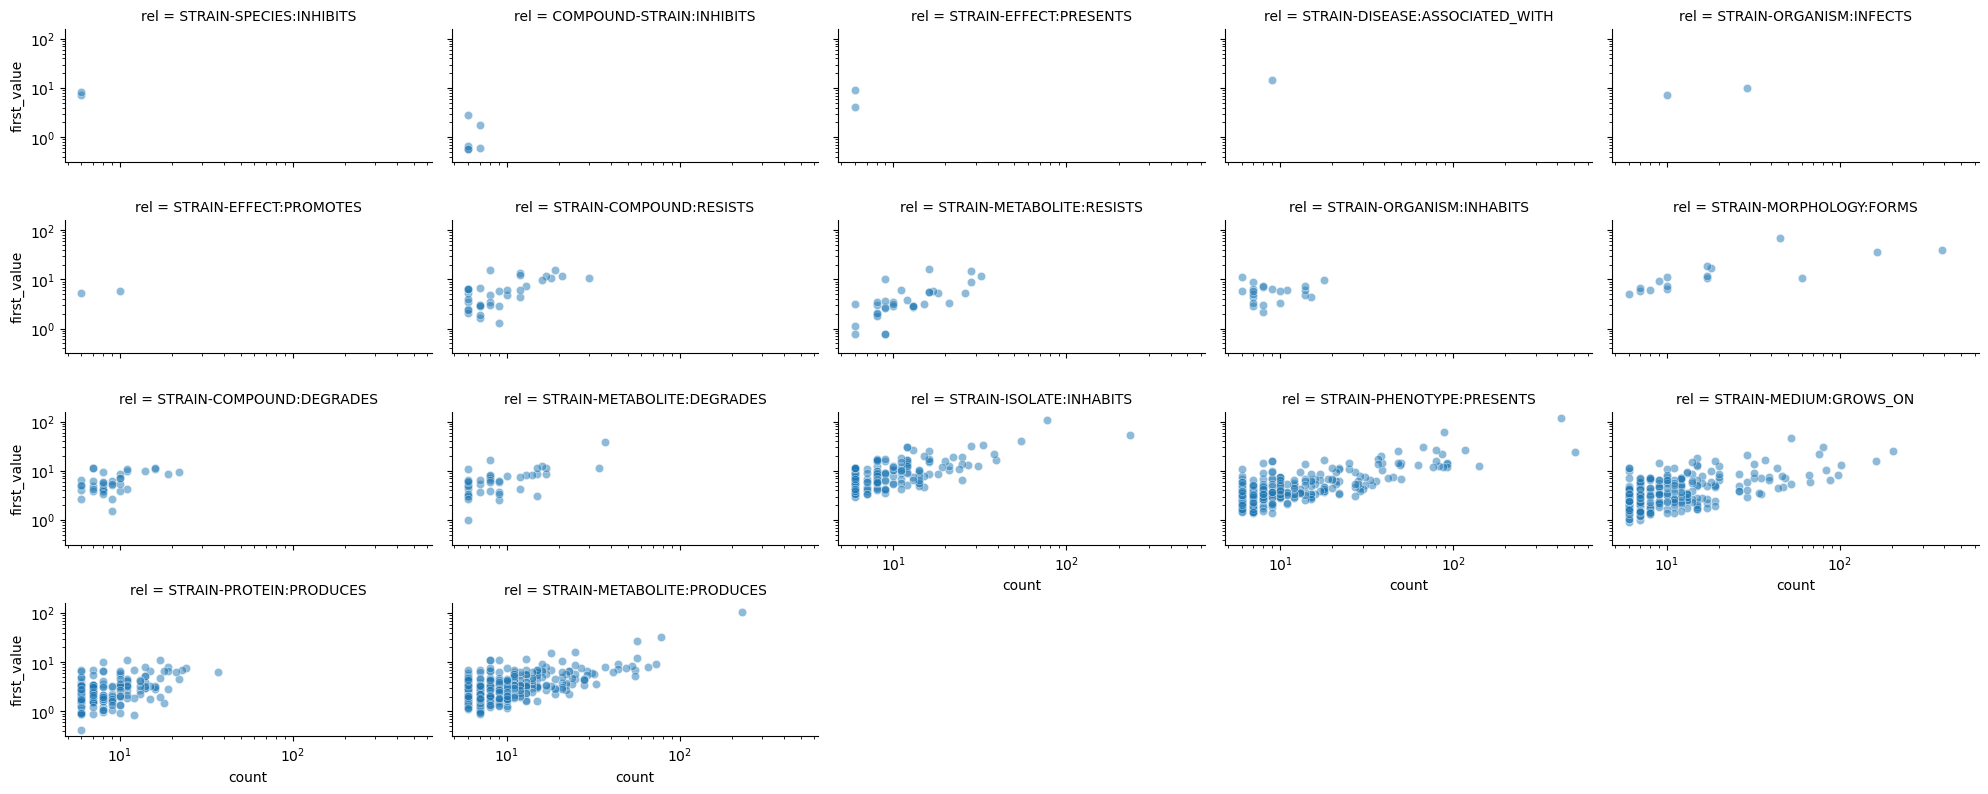

In [19]:
sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [20]:
merged_df['normalized_value'] = (merged_df['first_value'] * merged_df['count'])/100

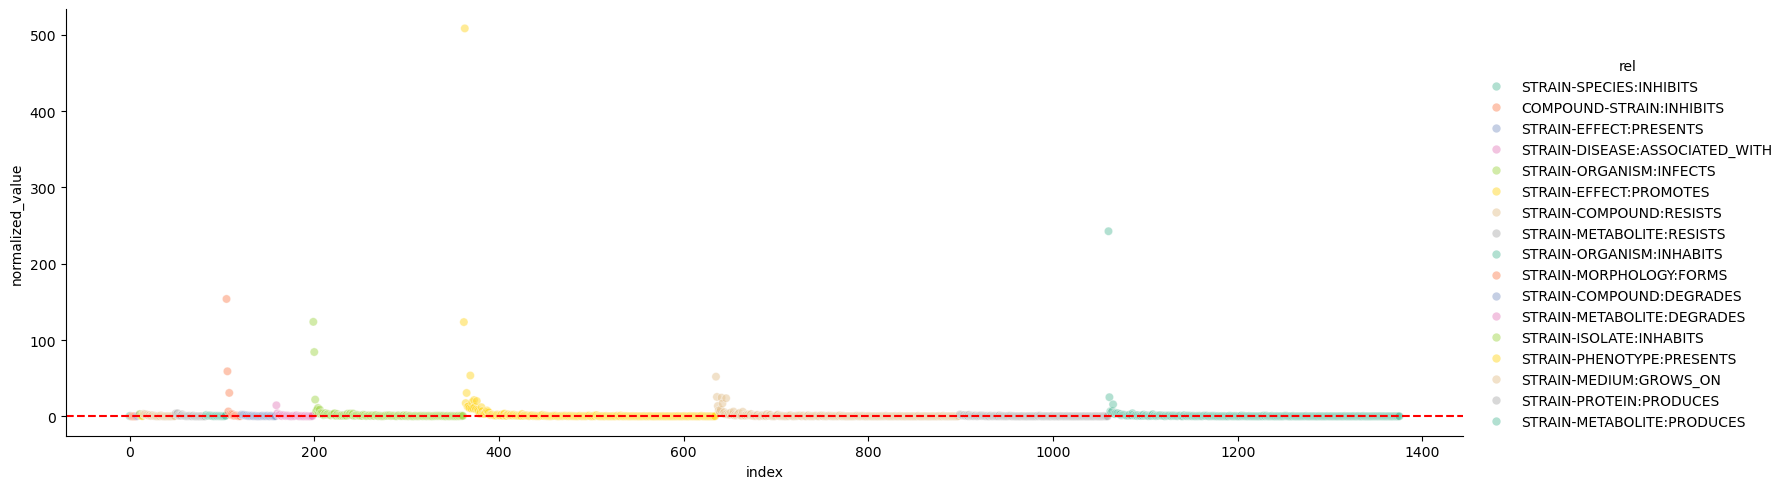

In [21]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [22]:
merged_df.sort_values("normalized_value")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value
1052,STRAIN-PROTEIN:PRODUCES,dd,0.416664,"Protein-tyrosine phosphatase, catalytic",0.373756,"Glycosyl transferase, family 8",0.364599,Dual specificity protein phosphatase domain,0.002127,"Primase, C-terminal 2",6,0.025000
4,COMPOUND-STRAIN:INHIBITS,eos,0.560589,Sodium/calcium exchanger membrane region,0.554175,Endonuclease/exonuclease/phosphatase superfamily,0.521822,"Pirin, C-terminal domain",0.017751,"Phage portal protein, lambda family",6,0.033635
7,COMPOUND-STRAIN:INHIBITS,bromolactones,0.560589,Sodium/calcium exchanger membrane region,0.554175,Aspartyl/glutamyl-tRNA amidotransferase subuni...,0.468298,N-acetylglucosamine-6-phosphate deacetylase,0.005477,"Phage portal protein, lambda family",6,0.033635
5,COMPOUND-STRAIN:INHIBITS,388,0.673396,Peptide resistance ABC transporter activity mo...,0.060254,"Phage portal protein, lambda family",0.000000,,0.000000,,6,0.040404
2,COMPOUND-STRAIN:INHIBITS,silver(i) complexes,0.590841,"Ribonucleotide reductase large subunit, C-term...",0.046518,"Type VI secretion system, RhsGE-associated Vgr...",0.002580,Peptidase S26,0.001536,"Resolvase-like, N-terminal catalytic domain su...",7,0.041359
...,...,...,...,...,...,...,...,...,...,...,...,...
362,STRAIN-PHENOTYPE:PRESENTS,gram - negative,24.312550,"Fe(2+)-dicitrate sensor, transmembrane component",23.994677,"Ferredoxin--NADP reductase, bacteria",23.657700,Protein of unknown function DUF1287,0.019615,Putative methionine gamma-lyase,508,123.507752
199,STRAIN-ISOLATE:INHABITS,soil,52.905560,Condensation domain,33.917496,Non-ribosomal peptide synthase,24.342966,ACP-like superfamily,0.021487,Restriction system protein Mrr-like N-terminal...,234,123.799009
105,STRAIN-MORPHOLOGY:FORMS,biofilm,39.841034,Helicase SWF/SNF-related,34.578350,Inositol monophosphatase-like,21.493536,"Large ribosomal subunit protein eL14, KOW motif",0.001648,Phosphofructokinase domain,386,153.786391
1060,STRAIN-METABOLITE:PRODUCES,c,105.438171,Pr6Pr membrane protein-like,61.823261,"Aspartate-tRNA ligase, type 1, anticodon recog...",51.560860,"Orc1-like, AAA ATPase domain",0.002101,"Phosphoenolpyruvate carboxykinase, ATP-utilising",230,242.507794


#### Find features where top three are very close

In [23]:
merged_df["first_second_difference"] = merged_df.first_value - merged_df.second_value
merged_df["first_third_difference"] = merged_df.first_value - merged_df.third_value

In [24]:
merged_df[merged_df["first_second_difference"] <0.01]

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference
4,COMPOUND-STRAIN:INHIBITS,eos,0.560589,Sodium/calcium exchanger membrane region,0.554175,Endonuclease/exonuclease/phosphatase superfamily,0.521822,"Pirin, C-terminal domain",0.017751,"Phage portal protein, lambda family",6,0.033635,0.006413,0.038767
7,COMPOUND-STRAIN:INHIBITS,bromolactones,0.560589,Sodium/calcium exchanger membrane region,0.554175,Aspartyl/glutamyl-tRNA amidotransferase subuni...,0.468298,N-acetylglucosamine-6-phosphate deacetylase,0.005477,"Phage portal protein, lambda family",6,0.033635,0.006413,0.092290
77,STRAIN-METABOLITE:RESISTS,amikacin,3.003643,"Ferritin-like, di-iron-binding domain",3.003624,MetI-like superfamily,3.000927,ABC3 transporter permease protein domain,0.000414,"Serralysin-like metalloprotease, C-terminal",8,0.240291,0.000019,0.002716
90,STRAIN-ORGANISM:INHABITS,tomato,3.242899,Insecticide toxin TcdB middle/C-terminal,3.234089,"Molybdenum cofactor biosynthesis, conserved site",3.182314,"Stress-induced protein, KGG, repeat",0.004788,"DUF2875, N-terminal domain",10,0.324290,0.008811,0.060585
138,STRAIN-COMPOUND:DEGRADES,pcbs,1.548767,Multidrug resistance protein MdtK-like,1.541880,"2-hydroxy-6-oxo-6-phenylhexa-2,4-dienoate hydr...",1.497976,Branched-chain aminotransferase,0.014532,"Cytochrome P450, E-class, group I",9,0.139389,0.006888,0.050791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,STRAIN-METABOLITE:PRODUCES,n-butanol,0.925509,Bacterial microcompartment domain,0.917480,"Cellulase, Ig-like domain",0.915710,Peptidoglycan-N-acetylmuramic acid deacetylase...,0.011492,Pyridoxal phosphate-dependent transferase,7,0.064786,0.008029,0.009799
1316,STRAIN-METABOLITE:PRODUCES,heme,6.038965,"Transcription regulator, HipB-like",6.038900,Domain of unknown function DUF4595 with porin-...,6.035114,Cleaved adhesin,0.060170,"DNA-binding HTH domain, TetR-type",6,0.362338,0.000065,0.003851
1317,STRAIN-METABOLITE:PRODUCES,coa,2.048605,"Phosphotransferase system, HPr histidine phosp...",2.047538,Protein of unknown function DUF1579,2.030737,"DNA-binding domain, IS481-type",0.016162,UDP-3-O-acyl N-acetylglucosamine deacetylase,6,0.122916,0.001067,0.017869
1329,STRAIN-METABOLITE:PRODUCES,diphosphatidylglycerol (,1.969209,Domain of unknown function DUF2062,1.966615,Peptide modification radical SAM enzyme,1.959590,FAD-linked oxidoreductase-like,0.001573,"Cytochrome C biogenesis protein, transmembrane...",6,0.118153,0.002595,0.009619


In [25]:
merged_df[merged_df["first_third_difference"] <0.01].sort_values("first_third_difference")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference
772,STRAIN-MEDIUM:GROWS_ON,tris,3.314026,Uncharacterised conserved protein YmfJ,3.313843,Acetoin utilization protein AcuA,3.313431,"CbbX, AAA lid domain",0.000300,Outer membrane lipoprotein Slp,9,0.298262,0.000183,0.000595
77,STRAIN-METABOLITE:RESISTS,amikacin,3.003643,"Ferritin-like, di-iron-binding domain",3.003624,MetI-like superfamily,3.000927,ABC3 transporter permease protein domain,0.000414,"Serralysin-like metalloprotease, C-terminal",8,0.240291,0.000019,0.002716
1316,STRAIN-METABOLITE:PRODUCES,heme,6.038965,"Transcription regulator, HipB-like",6.038900,Domain of unknown function DUF4595 with porin-...,6.035114,Cleaved adhesin,0.060170,"DNA-binding HTH domain, TetR-type",6,0.362338,0.000065,0.003851
485,STRAIN-PHENOTYPE:PRESENTS,plant growth-promoting,2.934033,Pyocin S killer protein,2.929163,Ribosome-inactivating protein,2.928898,Protein of unknown function DUF3275,0.003494,"Lipoprotein YgdI/YgdR-like, SH3-like domain",10,0.293403,0.004871,0.005135
622,STRAIN-PHENOTYPE:PRESENTS,pigmented,2.945866,REDY-like protein HapK,2.943057,"Phosphotransferase system, sugar-specific perm...",2.940121,Trypsin-co-occurring domain 2,0.018856,Protein of unknown function DUF599,6,0.176752,0.002809,0.005745
440,STRAIN-PHENOTYPE:PRESENTS,biocontrol,3.424408,Esterase-like,3.421005,"Protein-tyrosine phosphatase, active site",3.417725,"QsdR, TetR regulatory C-terminal domain",0.000352,"MobA/VirD2-like, nuclease domain",15,0.513661,0.003403,0.006683
959,STRAIN-PROTEIN:PRODUCES,f,0.936340,"Signal transduction response regulator, receiv...",0.931437,Glycosyltransferase family 92,0.928605,DEAD/DEAH box helicase domain,0.004126,IS481-like transposase,10,0.093634,0.004903,0.007736
1205,STRAIN-METABOLITE:PRODUCES,1-butanol,1.370799,Putative type IV secretory system protein,1.366426,DotD protein,1.362729,TniQ,0.002696,"Transcriptional repressor PaaX-like, N-terminal",9,0.123372,0.004372,0.008069
862,STRAIN-MEDIUM:GROWS_ON,bhi.,3.491119,Domain of unknown function DUF4203,3.487915,Cro/C1-type helix-turn-helix domain,3.482422,Putative DNA-binding domain,0.021692,"Integrase, catalytic core",6,0.209467,0.003204,0.008698
1042,STRAIN-PROTEIN:PRODUCES,nitrilase,2.507454,"Lysozyme inhibitor LprI, N-terminal",2.501428,Solute-binding protein family 3/N-terminal dom...,2.497934,SsuA/THI5-like,0.000248,"Signal transduction response regulator, receiv...",6,0.150447,0.006026,0.009520


## Evolution

### Example (do not run)

In [57]:
merged_df.iloc[485]

rel                                  STRAIN-PHENOTYPE:PRESENTS
ner                                     plant growth-promoting
first_value                                           2.934033
first_gene                             Pyocin S killer protein
second_value                                          2.929163
second_gene                      Ribosome-inactivating protein
third_value                                           2.928898
third_gene                 Protein of unknown function DUF3275
count                                                       10
normalized_value                                      0.293403
first_second_difference                               0.004871
first_third_difference                                0.005135
Name: 485, dtype: object

In [58]:
parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{merged_df.iloc[485].rel}.parquet")

In [59]:
strains = parq[parq["word_qc"]==merged_df.iloc[485].ner].sa_ner.str.split("_",expand=True)[0].unique()

In [60]:
protein_ids = parq[parq["InterPro_description"]== merged_df.iloc[485].first_gene].Protein_accession.unique()

In [61]:

output_faa = []
for s in strains:
	strain = s.replace(" ","_")
	# Check if the folder exists
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			faa_files = glob(f"{folder_path}/{assembly}/*.faa")
			if faa_files:
				faa_file = faa_files[0]
				for record in SeqIO.parse(faa_file, "fasta"):
					if record.id in protein_ids:
						output_faa.append(record)

with open("test.faa","w") as f:
	SeqIO.write(output_faa, f, "fasta")

In [64]:
output_fna = []
for s in strains:
	strain = s.replace(" ","_")
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
			if fna_files:
				fna_file = fna_files[0]
				for record in SeqIO.parse(fna_file, "fasta"):
					if record.id in protein_ids:
						output_fna.append(record)
with open("test.fna","w") as f:
	SeqIO.write(output_fna, f, "fasta")

### Run for all rows in merged_df and save files into a folder each

In [28]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("''",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['first_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

### Create test set

In [29]:
# outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
# os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("''",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [ ]:

# Set the directory where the files are located
directory = "/home/gomez/gomez/seqfiles_linkbert_810_5"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(directory)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)
